In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math

from subprocess import check_output
#print(check_output(["ls", "./input"]).decode("utf8"))

In [4]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [5]:
#LOAD DATA
print("Loading data...")
train = pd.read_table("./input/train.tsv")
test = pd.read_table("./input/test.tsv")
print(train.shape)
print(test.shape)

Loading data...
(1482535, 8)
(693359, 7)


In [6]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [7]:
#HANDLE MISSING VALUES
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...
(1482535, 8)
(693359, 7)


In [8]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [9]:
#PROCESS CATEGORICAL DATA
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


In [10]:
#PROCESS TEXT: RAW
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [11]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), 
                       np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


<AxesSubplot:>

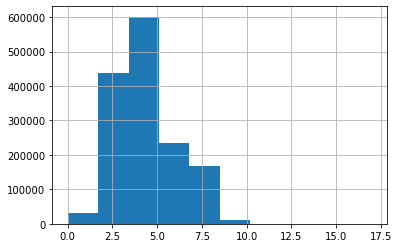

In [12]:
train.seq_name.apply(lambda x: len(x)).hist()

<AxesSubplot:>

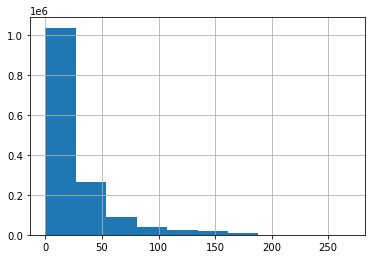

In [13]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [14]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

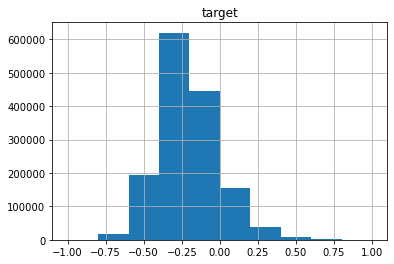

In [16]:
# 가격 -> 로그(가격) -> 표준정규화(로그(가격))
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))
pd.DataFrame(train.target).hist()

In [17]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


In [24]:
dtrain

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name,target
407853,407853,maroon velvet lisette shorts,1,1162,737,22.0,1,brand new from brandy melville,"[16, 5, 43, 536, 587]","[836, 1038, 18025, 129]",-0.175509
748699,748699,Benefit Roller Lash Mascara FULL SIZE,2,26,574,14.0,1,Benefit Roller Lash Mascara FULL SIZE in the c...,"[1232, 2593, 1292, 643, 152, 6, 7, 2, 48, 24, ...","[1232, 2593, 1292, 643, 152, 6]",-0.287907
320295,320295,Holographic Ipsy Bag,2,1303,5265,7.0,0,Used once,"[31, 96]","[2875, 2240, 101]",-0.453202
1094144,1094144,Samsung galaxy on5 10/10 con. W/metropcs,2,81,4121,40.0,1,No description yet,"[12, 68, 79]","[440, 438, 12298, 95, 95, 3901, 245, 11128]",-0.023501
1310650,1310650,Country Heat,2,97,5265,28.0,0,Comes with 4 DVDs and a bonus DVD. Also comes ...,"[103, 9, 47, 2354, 1, 4, 2205, 699, 154, 103, ...","[2215, 1160]",-0.114556
...,...,...,...,...,...,...,...,...,...,...,...
1241052,1241052,Urban Decay Naked Skin Foundation,3,29,5265,15.0,1,"About 80% or more full, no lid. Shade 2.0. Loo...","[222, 1716, 23, 86, 152, 12, 1398, 428, 22, 20...","[417, 677, 1108, 191, 405]",-0.270936
1066306,1066306,VS LOVE SPELL MIST,1,11,4953,13.0,0,Brand new 8.4 fl oz,"[16, 5, 81, 47, 507, 151]","[105, 204, 2946, 822]",-0.306049
28030,28030,F21 Floral Sweatshirt,2,1259,1646,14.0,0,I'm not sure if my daughter ever wore this. It...,"[243, 40, 372, 65, 33, 1334, 935, 413, 29, 19,...","[2529, 283, 560]",-0.287907
277869,277869,Necklace pearl stones,1,1204,5265,23.0,0,"jewelry necklace, Biwa Pearl Stones, 19.5 inch...","[448, 257, 50608, 1010, 1424, 1390, 34, 511, 1...","[257, 1010, 1424]",-0.164318


In [18]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ) # (1467709, 10)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ) # (1467709, 75)
        ,'brand_name': np.array(dataset.brand_name) # (1467709,)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [28]:
pad_sequences(dtrain.seq_name, maxlen=MAX_NAME_SEQ).shape

(1467709, 10)

In [27]:
np.array(dtrain.brand_name).shape

(1467709,)

In [19]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                              

In [20]:
#FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Epoch 1/5
74/74 [==============================] - 226s 3s/step - loss: 0.0294 - mae: 0.1303 - rmsle_cust: 0.0156 - val_loss: 0.0184 - val_mae: 0.1030 - val_rmsle_cust: 0.0135
Epoch 2/5
74/74 [==============================] - 212s 3s/step - loss: 0.0182 - mae: 0.1022 - rmsle_cust: 0.0133 - val_loss: 0.0162 - val_mae: 0.0965 - val_rmsle_cust: 0.0128
Epoch 3/5
74/74 [==============================] - 222s 3s/step - loss: 0.0161 - mae: 0.0960 - rmsle_cust: 0.0126 - val_loss: 0.0155 - val_mae: 0.0945 - val_rmsle_cust: 0.0125
Epoch 4/5
74/74 [==============================] - 197s 3s/step - loss: 0.0149 - mae: 0.0924 - rmsle_cust: 0.0122 - val_loss: 0.0154 - val_mae: 0.0937 - val_rmsle_cust: 0.0124
Epoch 5/5
74/74 [==============================] - 193s 3s/step - loss: 0.0142 - mae: 0.0901 - rmsle_cust: 0.0119 - val_loss: 0.0153 - val_mae: 0.0940 - val_rmsle_cust: 0.0123


In [21]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.4867783380584693


In [22]:
#CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

C:\Users\HOME\AppData\Local\Temp/ipykernel_17412/2545304726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["price"] = preds


<AxesSubplot:>

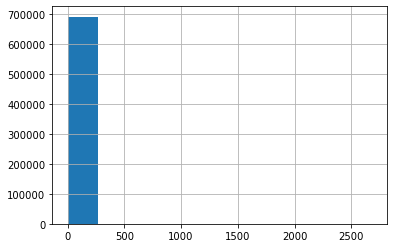

In [23]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()

이것은 nn이 이 문제를 해결할 수 있는 방법의 예일 뿐입니다. 커널의 잠재적인 개선 사항:
     - 임베딩 팩터 증가
     - 배치 크기 줄이기
     - 일괄 정규화 추가
     - LSTM, 양방향 RNN, 스택 RNN 시도
     - 더 조밀한 레이어 또는 더 많은 rnn 출력으로 시도
     - 등. 아니면 새로운 아키텍처를 시도해보세요!
    
어떤 의견이든 환영합니다. 감사해요!